In [1]:
# Standard Libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Scikit-learn
from sklearn.metrics import confusion_matrix
# Keras
from keras import Sequential, Model
from keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Dropout, Dense, Flatten)
from keras.callbacks import EarlyStopping

2024-08-12 18:17:00.397069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 18:17:00.397180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 18:17:00.536860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Objects to hold pairs of images and masks
train_image_mask = {
    'images': [],
    'masks': []
}

test_image_mask = {
    'images': [],
    'masks': []
}

# Objects to hold pairs of images and labels
train_image_class = {
    'images': [],
    'labels': []
}

test_image_class = {
    'images': [],
    'labels': []
}

def load_image_mask(train_image_mask=None, test_image_mask=None, image_path=None, shape=256):
    """Generates image/mask pairs from the dataset.

    Args:
        train_image_mask (dict): Dictionary to store training images and masks.
        test_image_mask (dict): Dictionary to store testing images and masks.
        image_path (str): Path to the images and masks.
        shape (int): Size to resize images and masks.

    Returns:
        tuple: Updated dictionaries containing images and masks.
    """
    file_names = os.listdir(image_path)
    
    image_names = []
    mask_names = []
    partial_names = [fn.split(')')[0] for fn in file_names]
    
    partial_names = list(set(partial_names))
    
    for name in partial_names:
        image_names.append(name + ').png')
        mask_names.append(name + ')_mask.png')
        
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        mask = plt.imread(os.path.join(image_path, mask_names[i]))
        
        image = cv2.resize(image, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        
        if i < train_test_split_index:
            train_image_mask['images'].append(image)
            train_image_mask['masks'].append(mask)
        else:
            test_image_mask['images'].append(image)
            test_image_mask['masks'].append(mask)
        
    return train_image_mask, test_image_mask

def load_image_class(train_image_class=None, test_image_class=None, image_path=None, shape=256):
    """Generates image/label pairs from the dataset.

    Args:
        train_image_class (dict): Dictionary to store training images and labels.
        test_image_class (dict): Dictionary to store testing images and labels.
        image_path (str): Path to the images.
        shape (int): Size to resize images.

    Returns:
        tuple: Updated dictionaries containing images and labels.
    """
    file_names = os.listdir(image_path)
    image_class = os.path.basename(image_path)
    
    image_names = [fn.split(')')[0] + ').png' for fn in file_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        image = cv2.resize(image, (shape, shape))
        
        if i < train_test_split_index:
            train_image_class['images'].append(image)
            train_image_class['labels'].append(image_class)
        else:
            test_image_class['images'].append(image)
            test_image_class['labels'].append(image_class)
        
    return train_image_class, test_image_class

In [3]:
from pathlib import Path

base_dir = Path("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")
categories = ['normal', 'benign', 'malignant']

for category in categories:
    image_dir = base_dir / category / 'images'
    mask_dir = base_dir / category / 'masks'
    
    print(f"Checking directories for category '{category}':")
    print(f"Images directory: {image_dir}")
    print(f"Masks directory: {mask_dir}")

    if image_dir.exists():
        print("Images directory exists.")
        print(list(image_dir.iterdir()))  # List files in the images directory
    else:
        print(f"Error: Images directory {image_dir} does not exist.")

    if mask_dir.exists():
        print("Masks directory exists.")
        print(list(mask_dir.iterdir()))  # List files in the masks directory
    else:
        print(f"Error: Masks directory {mask_dir} does not exist.")


Checking directories for category 'normal':
Images directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/images
Masks directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/masks
Error: Images directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/images does not exist.
Error: Masks directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/masks does not exist.
Checking directories for category 'benign':
Images directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/images
Masks directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/masks
Error: Images directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/images does not exist.
Error: Masks directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/masks does not exist.
Checking directories for categor

In [4]:
# Load Benign class images and masks
train_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    test_image_mask=test_image_mask, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
)

train_image_class, test_image_class = load_image_class(
    train_image_class=train_image_class, 
    test_image_class=test_image_class, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
)

# Load Malignant class images and masks
train_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    test_image_mask=test_image_mask, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
)

train_image_class, test_image_class = load_image_class(
    train_image_class=train_image_class, 
    test_image_class=test_image_class, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
)


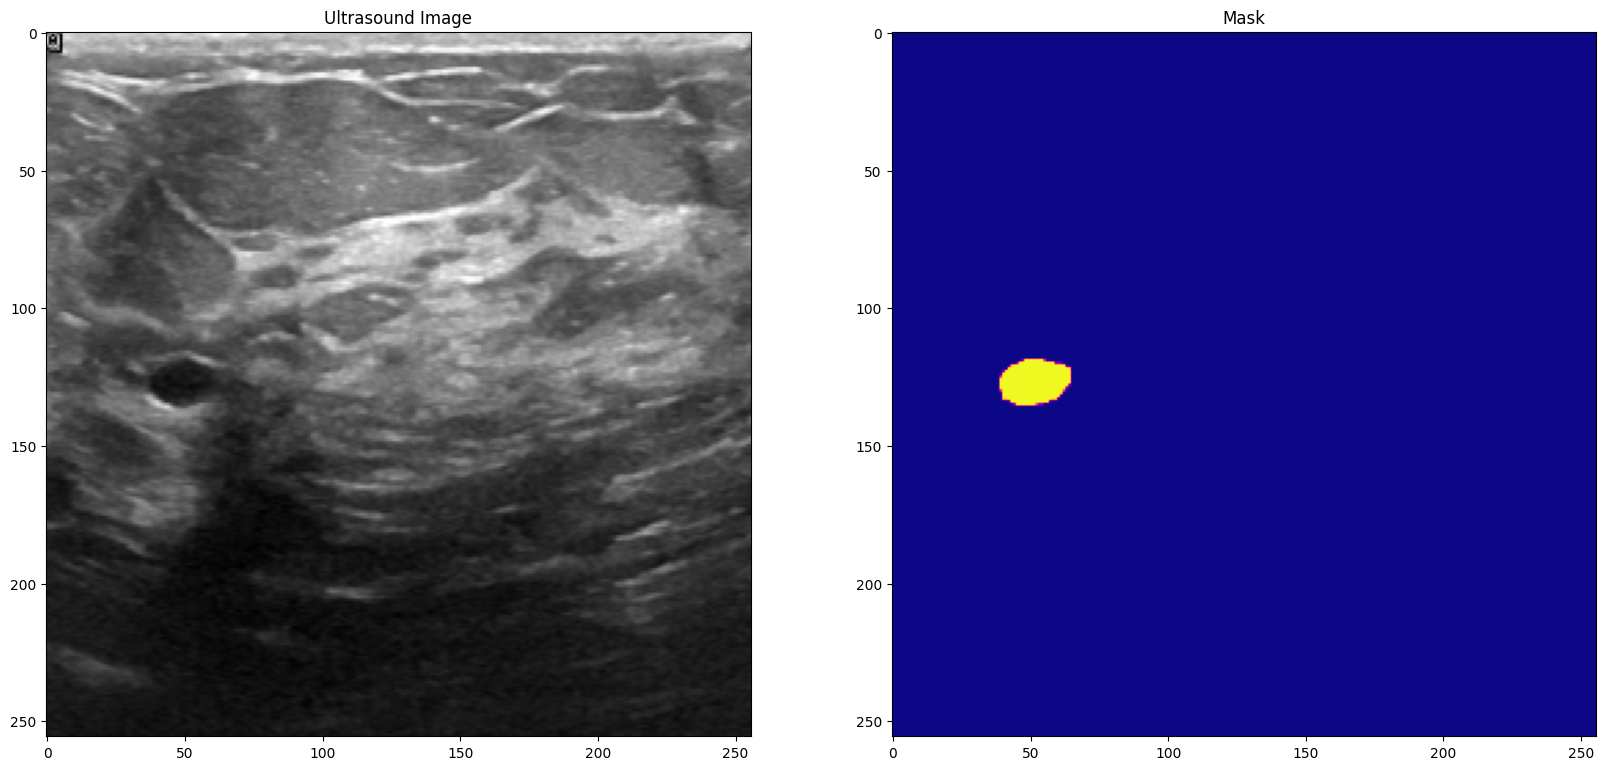

In [5]:
# Display one image/mask pair from the loaded dataset
plt.figure(figsize=(20, 20))

# Display the ultrasound image
plt.subplot(1, 2, 1)
plt.imshow(train_image_mask['images'][0])
plt.title('Ultrasound Image')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(train_image_mask['masks'][0], cmap='plasma')
plt.title('Mask')

plt.show()

In [6]:
# Definition of one Convolution block of the U-Net architecture
def convolutionBlock(inputTensor, filterCount, kernelSize = 3):
    convolutionBlock = Conv2D(filters = filterCount, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(inputTensor)
    convolutionBlock = BatchNormalization()(convolutionBlock)
    convolutionBlock = Activation('relu')(convolutionBlock)
    
    convolutionBlock = Conv2D(filters = filterCount, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(convolutionBlock)
    convolutionBlock = BatchNormalization()(convolutionBlock)
    convolutionBlock = Activation('relu')(convolutionBlock)
    
    return convolutionBlock

# Definition of the entire U-Net architecture
def modelArchitecture(inputTensor, filterCount = 16, dropoutRate = 0.1):
    # Initialization of the encoder
    firstConvolution = convolutionBlock(inputTensor, filterCount)
    firstLayer = AveragePooling2D((2, 2))(firstConvolution)
    firstLayer = Dropout(dropoutRate)(firstLayer)
    
    secondConvolution = convolutionBlock(firstLayer, filterCount * 2)
    secondLayer = AveragePooling2D((2, 2))(secondConvolution)
    secondLayer = Dropout(dropoutRate)(secondLayer)
    
    thirdConvolution = convolutionBlock(secondLayer, filterCount * 4)
    thirdLayer = AveragePooling2D((2, 2))(thirdConvolution)
    thirdLayer = Dropout(dropoutRate)(thirdLayer)
    
    fourthConvolution = convolutionBlock(thirdLayer, filterCount * 8)
    fourthLayer = AveragePooling2D((2, 2))(fourthConvolution)
    fourthLayer = Dropout(dropoutRate)(fourthLayer)
    
    fifthConvolution = convolutionBlock(fourthLayer, filterCount * 16)
    
    # Initialization of the decoder
    firstDeconvolution = Conv2DTranspose(filterCount * 8, (3, 3), strides = (2, 2), padding = 'same')(fifthConvolution)
    sixthLayer = concatenate([firstDeconvolution, fourthConvolution])
    sixthLayer = Dropout(dropoutRate)(sixthLayer)
    sixthConvolution = convolutionBlock(sixthLayer, filterCount * 8)
    
    secondDeconvolution = Conv2DTranspose(filterCount * 4, (3, 3), strides = (2, 2), padding = 'same')(sixthConvolution)
    seventhLayer = concatenate([secondDeconvolution, thirdConvolution])
    seventhLayer = Dropout(dropoutRate)(seventhLayer)
    seventhConvolution = convolutionBlock(seventhLayer, filterCount * 4)
    
    thirdDeconvolution = Conv2DTranspose(filterCount * 2, (3, 3), strides = (2, 2), padding = 'same')(seventhConvolution)
    eighthLayer = concatenate([thirdDeconvolution, secondConvolution])
    eighthLayer = Dropout(dropoutRate)(eighthLayer)
    eighthConvolution = convolutionBlock(eighthLayer, filterCount * 2)
    
    fourthDeconvolution = Conv2DTranspose(filterCount, (3, 3), strides = (2, 2), padding = 'same')(eighthConvolution)
    ninthLayer = concatenate([fourthDeconvolution, firstConvolution])
    ninthLayer = Dropout(dropoutRate)(ninthLayer)
    ninthConvolution = convolutionBlock(ninthLayer, filterCount)
    
    outputLayer = Conv2D(1, (1, 1), activation = 'sigmoid')(ninthConvolution)
    segmentationModel = Model(inputs = [inputTensor], outputs = [outputLayer])
    
    return segmentationModel

In [7]:
# Initialization of the segmentation model
inputs = Input((256, 256, 3))

segmentationModel = modelArchitecture(inputs, dropoutRate = 0.1)
segmentationModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
segmentationModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ average_pooling2

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [8]:
history = segmentationModel.fit(
    np.array(train_image_mask['images']), 
    np.array(train_image_mask['masks']),
    epochs=75,
    validation_data=(
        np.array(test_image_mask['images']), 
        np.array(test_image_mask['masks'])
    ),
    callbacks=[
        EarlyStopping(
            patience=15, 
            monitor='val_loss', 
            mode='min', 
            restore_best_weights=True, 
            verbose=1
        )
    ]
)


Epoch 1/75


2024-08-12 18:18:01.666698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.96116, expected 2.28267
2024-08-12 18:18:01.666758: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13388, expected 3.45539
2024-08-12 18:18:01.666768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.32371, expected 3.64522
2024-08-12 18:18:01.666776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.43312, expected 4.75463
2024-08-12 18:18:01.666784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.46228, expected 4.78378
2024-08-12 18:18:01.666792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.69444, expected 5.01594
2024-08-12 18:18:01.666800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.74803, expected 4.06954
2024-08-12 18:18:01.666807: E external/local_xla/xla/se

 1/17 ━━━━━━━━━━━━━━━━━━━━ 14:13 53s/step - accuracy: 0.6220 - loss: 0.6955

I0000 00:00:1723486714.678510      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7208 - loss: 0.6207

2024-08-12 18:18:44.990662: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196608: 3.34663, expected 2.36218
2024-08-12 18:18:44.990724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196609: 5.38306, expected 4.39862
2024-08-12 18:18:44.990733: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196610: 5.72677, expected 4.74232
2024-08-12 18:18:44.990741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196611: 6.54726, expected 5.56281
2024-08-12 18:18:44.990749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196612: 6.49276, expected 5.50831
2024-08-12 18:18:44.990757: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196613: 6.886, expected 5.90155
2024-08-12 18:18:44.990765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196614: 6.83541, expected 5.85096
2024-08-12 18:18:44.99

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7257 - loss: 0.6173   

2024-08-12 18:19:04.026607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.5087, expected 2.60868
2024-08-12 18:19:04.026665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.76634, expected 2.86632
2024-08-12 18:19:04.026674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.56132, expected 3.6613
2024-08-12 18:19:04.026682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.86986, expected 3.96984
2024-08-12 18:19:04.026690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.95629, expected 4.05627
2024-08-12 18:19:04.026698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.78347, expected 4.88345
2024-08-12 18:19:04.026706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.36935, expected 4.46933
2024-08-12 18:19:04.026714: E external/local_xla/xla/serv

17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7301 - loss: 0.6142 - val_accuracy: 0.1144 - val_loss: 12.7168
Epoch 2/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9202 - loss: 0.4016 - val_accuracy: 0.0895 - val_loss: 14.2263
Epoch 3/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9242 - loss: 0.3435 - val_accuracy: 0.1616 - val_loss: 11.6330
Epoch 4/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9261 - loss: 0.3085 - val_accuracy: 0.1325 - val_loss: 12.3909
Epoch 5/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9318 - loss: 0.2851 - val_accuracy: 0.2230 - val_loss: 9.2574
Epoch 6/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9344 - loss: 0.2625 - val_accuracy: 0.3167 - val_loss: 4.9972
Epoch 7/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9390 - loss: 0.2385 - val_accuracy: 0.7504 - val_loss: 1.1539
Epoch 8/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9409 - loss: 0.2243 - val_accuracy: 0.4736 - va

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

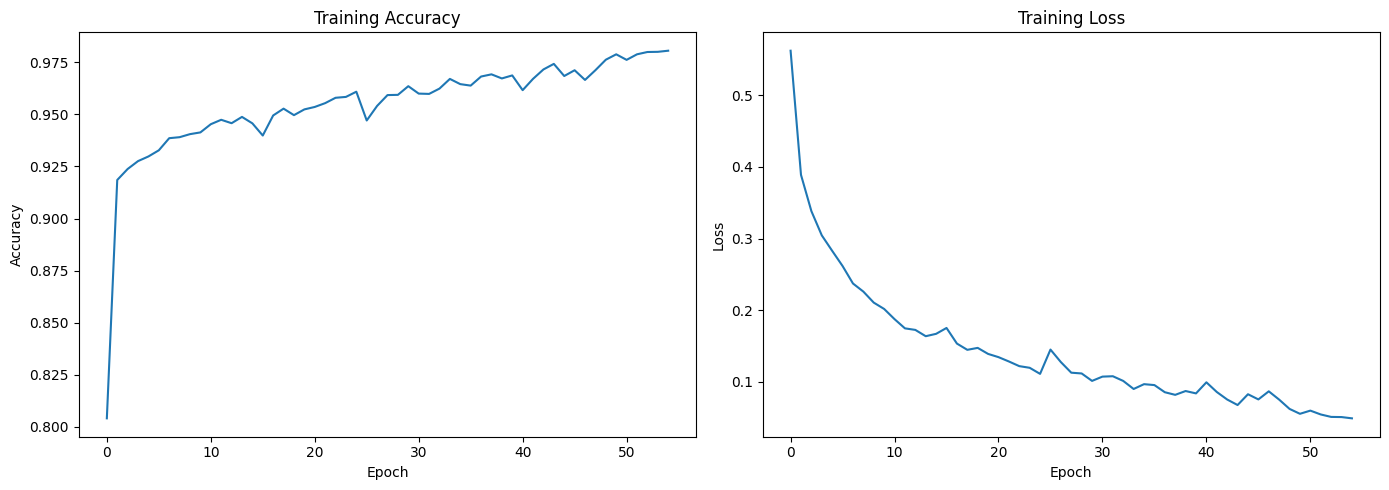

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

# Convert accuracy and loss to a DataFrame for easier plotting with Seaborn
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Loss': loss
})

# Create subplots to place the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Accuracy', ax=axes[0])
axes[0].set_title('Training Accuracy')

# Plot training loss using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Loss', ax=axes[1])
axes[1].set_title('Training Loss')

# Display the plots
plt.tight_layout()
plt.show()


In [10]:
testImages = test_image_mask['images']
testMasks = test_image_mask['masks']

predictions = segmentationModel.predict(np.array(testImages))
print(predictions.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step
(130, 256, 256, 1)


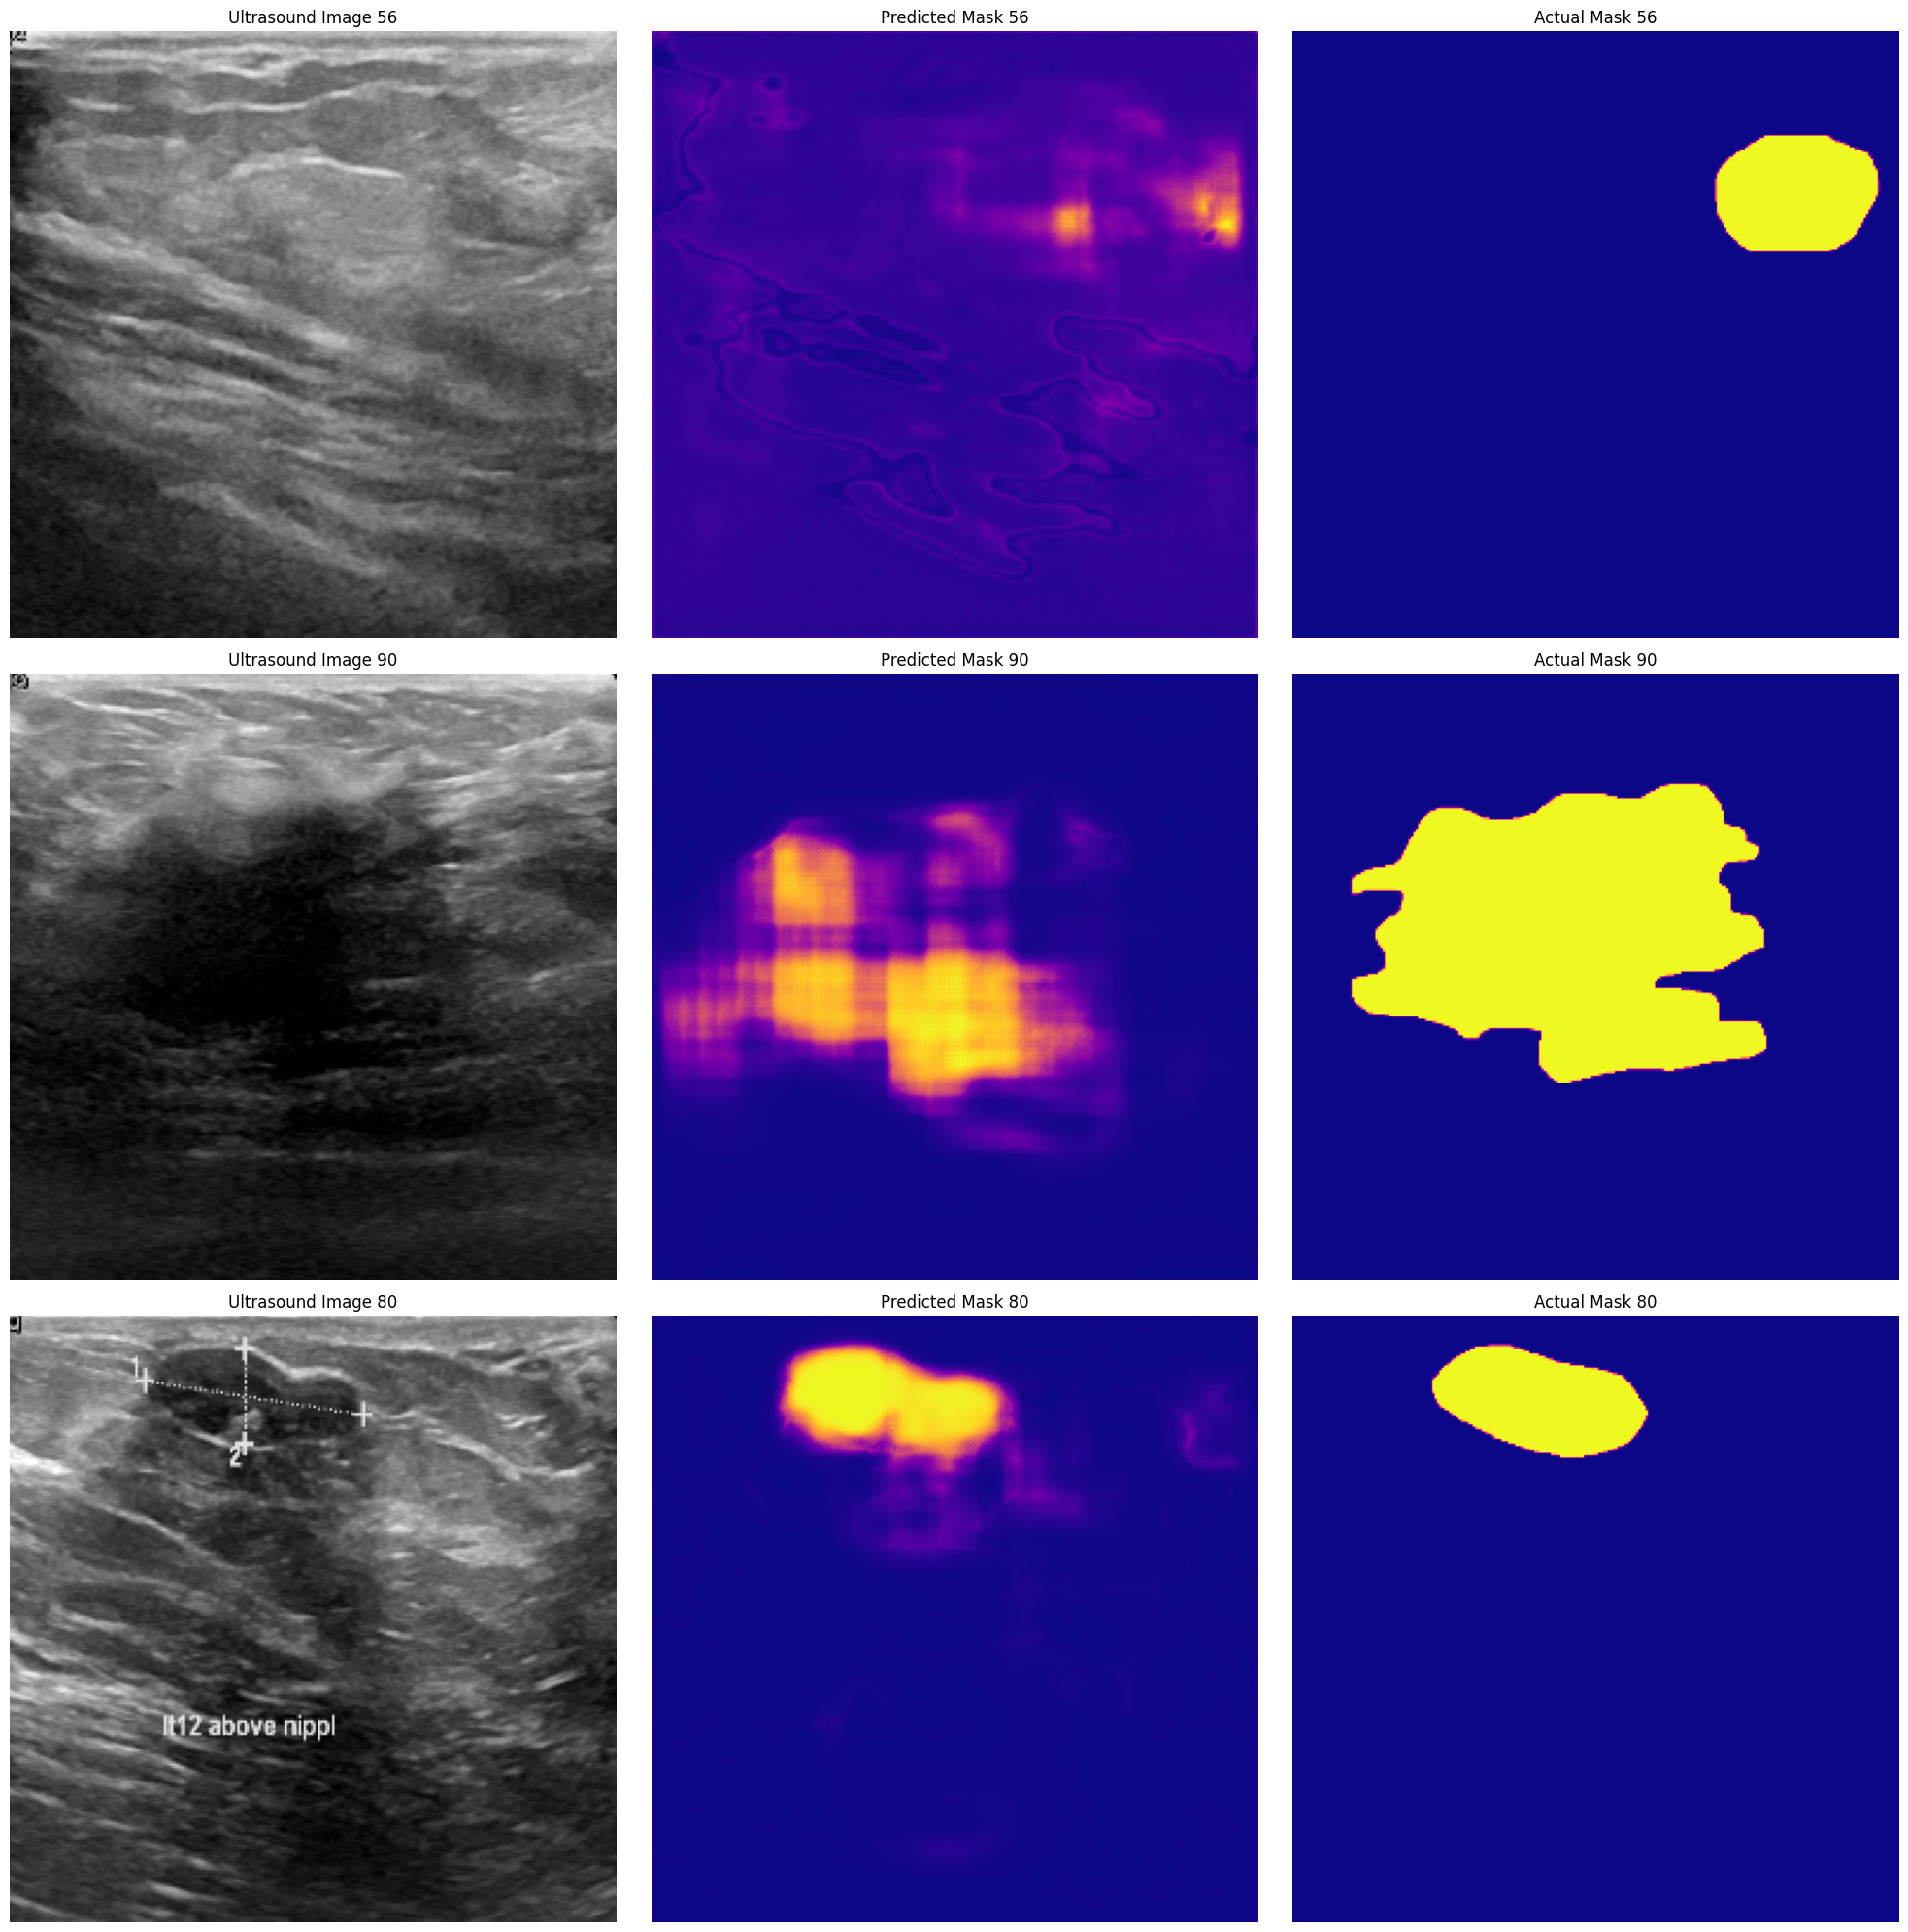

In [11]:
import matplotlib.pyplot as plt

# Define the indices for the images you want to plot
indices = [56, 90, 80]  # Modify these indices as needed

# Initialize the figure with a 3x3 grid
plt.figure(figsize=(20, 20))

# Loop over the indices and create subplots
for i, idx in enumerate(indices):
    # Determine the row and column for each image
    row = i // 3  # Row index (0 for the first row, 1 for the second row, etc.)
    col = i % 3   # Column index (0 for the first column, 1 for the second column, etc.)
    
    # Plot Ultrasound Image
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(testImages[idx])
    plt.title(f'Ultrasound Image {idx}')
    plt.axis('off')
    
    # Plot Predicted Mask
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(predictions[idx], cmap='plasma')
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')
    
    # Plot Actual Mask
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(testMasks[idx], cmap='plasma')
    plt.title(f'Actual Mask {idx}')
    plt.axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [12]:
segmentationModel.save('Breast Cancer Segmentation.h5')